# Note:
- This notebook file may contain methods or algorithms that are NOT covered by the teaching content of BT4222 and hence will not be assessed in your midterm exam.
- It serves to increase your exposure in depth and breath to the practical methods in addressing the specific project topic. We believe it will be helpful for your current project and also your future internship endeavors.

# Credit Card Fraud Detection using Autoencoders
The project trains an Autoencoder Neural Network in unsupervised (or semi-supervised) fashion for Anomaly Detection in credit card transaction data. The trained model will be evaluated on pre-labeled and anonymized dataset. We adopted this [tutorial](https://medium.com/@vkansal/credit-card-fraud-detection-using-deep-learning-pytorch-47f680a8c5be) for this part. The tutorial provides more detailed illustration of autodecoder for fraud detection.

The dataset is only a subset of the original Credit Card Fraud Detection dataset for the convenience of reproducing with limited computing resource, so the accuracy would be lower.

Using an autoencoder for fraud detection involves training a neural network to compress and then reconstruct input data. Normal transactions are learned during training. When new data is reconstructed with significantly higher error, it's likely an anomaly, possibly indicating fraud.

## Agenda

1. Loading the data
2. Exploration
3. Preparing the data
4. Autoencoders and Building the model
5. Evaluation
6. Reconstruction error without fraud

## Part 1: Loading the data
- Target: set up the environment and load the data

In [ ]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [ ]:
from google.colab import drive

import gdown

file_id = '1s3P67dsOL0Hh538zuiV0dS8fYYM-8sGd'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'creditcard_small.csv'
gdown.download(url, output, quiet=False)


df = pd.read_csv('creditcard_small.csv')

Downloading...
From: https://drive.google.com/uc?id=1s3P67dsOL0Hh538zuiV0dS8fYYM-8sGd
To: /content/creditcard_small.csv
100%|██████████| 10.5M/10.5M [00:00<00:00, 125MB/s]


## Part 2: Exploration
- Target: carry out exploratory data analysis on the loaded credit card transactions dataset

In [ ]:
# print the first five rows of the dataset to understand the structure and the types of the available data
df.head(5)
df['Class'].value_counts()

0    19914
1       85
Name: Class, dtype: int64

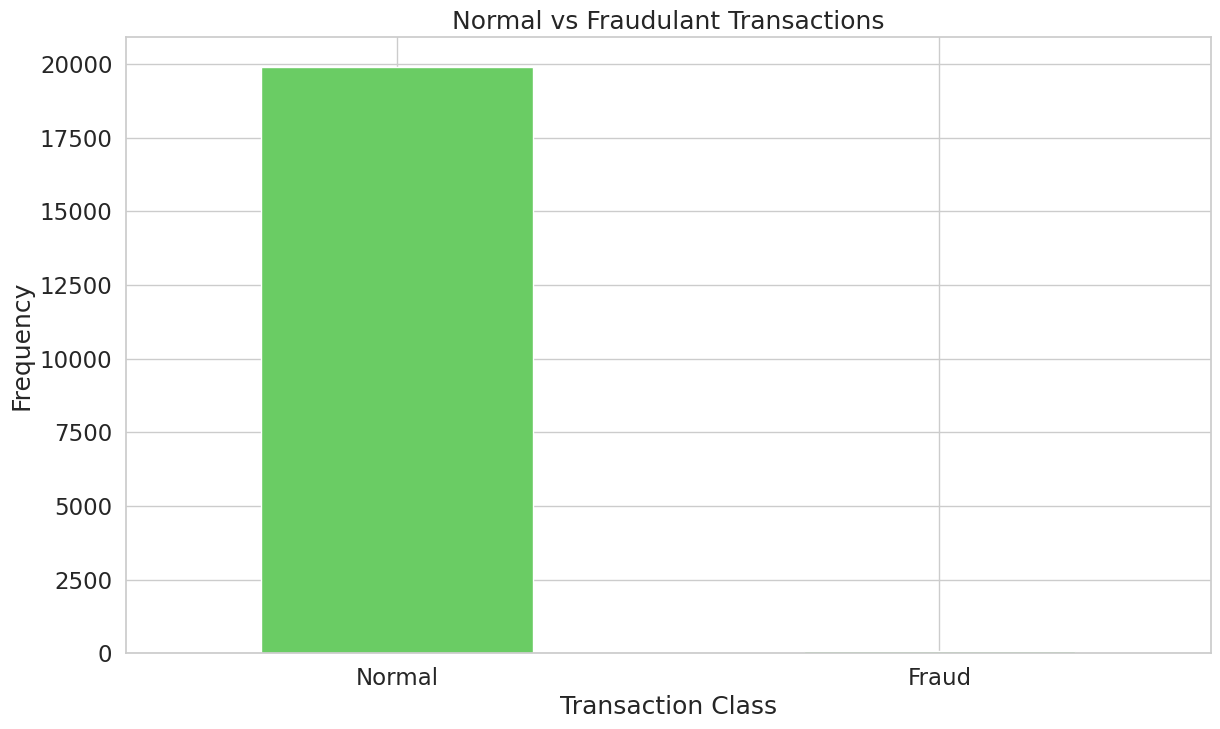

In [ ]:
# The 'Class' variable, which indicates whether a transaction is fraud or normal, is examined with a value count operation
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="g")
plt.title("Normal vs Fraudulant Transactions")
plt.xticks(range(2), LABELS)
plt.xlabel("Transaction Class")
plt.ylabel("Frequency");
fraudsDF = df[df.Class == 1]
normalDF = df[df.Class == 0]

The dataset is split into two separate dataframes - 'fraudsDF' for fraudulent transactions and 'normalDF' for normal transactions.

In [ ]:
fraudsDF.Amount.describe()

count      85.000000
mean       93.869647
std       261.736641
min         0.000000
25%         1.000000
50%         1.000000
75%        99.990000
max      1809.680000
Name: Amount, dtype: float64

In [ ]:
normalDF.Amount.describe()

count    19914.000000
mean        70.318532
std        205.786301
min          0.000000
25%          5.950000
50%         16.150000
75%         59.950000
max       7879.420000
Name: Amount, dtype: float64

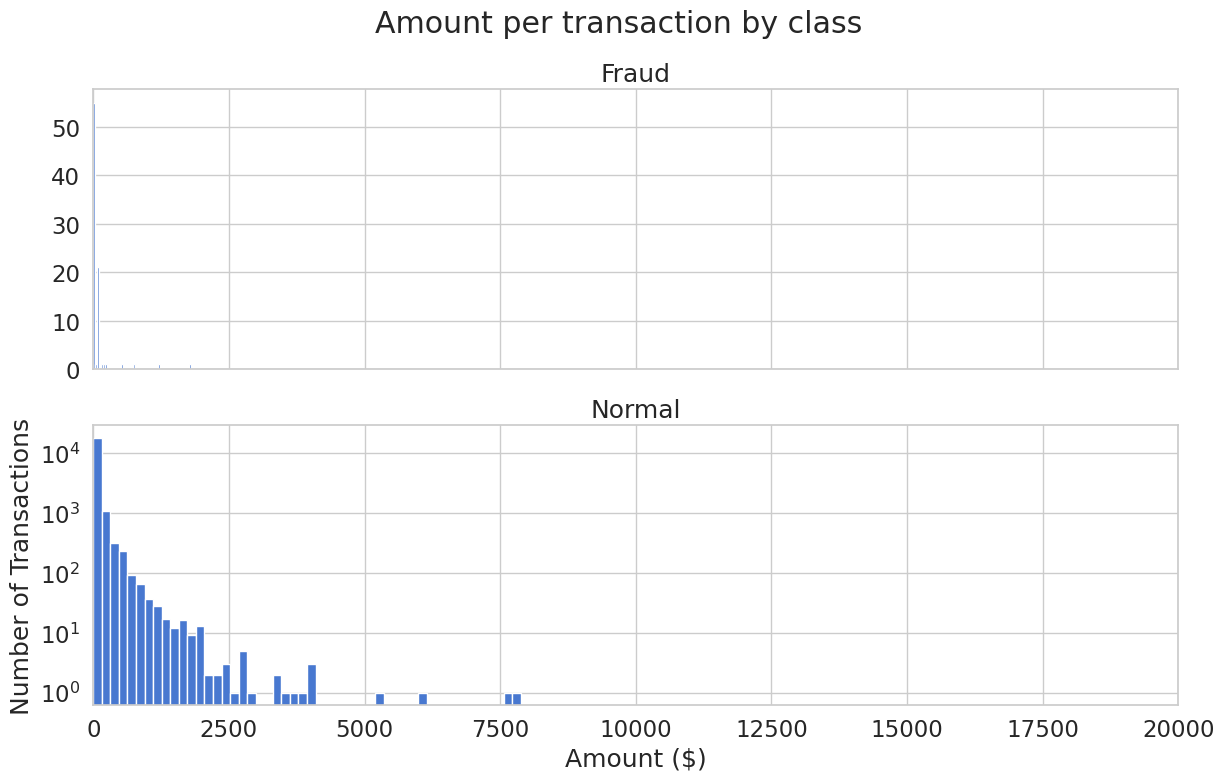

In [ ]:
# Two histogram plots are made for the transaction 'Amount' for each class (fraudulent and normal).
# These plots are to visualize the distribution of transaction amounts in both categories.
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(fraudsDF.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normalDF.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

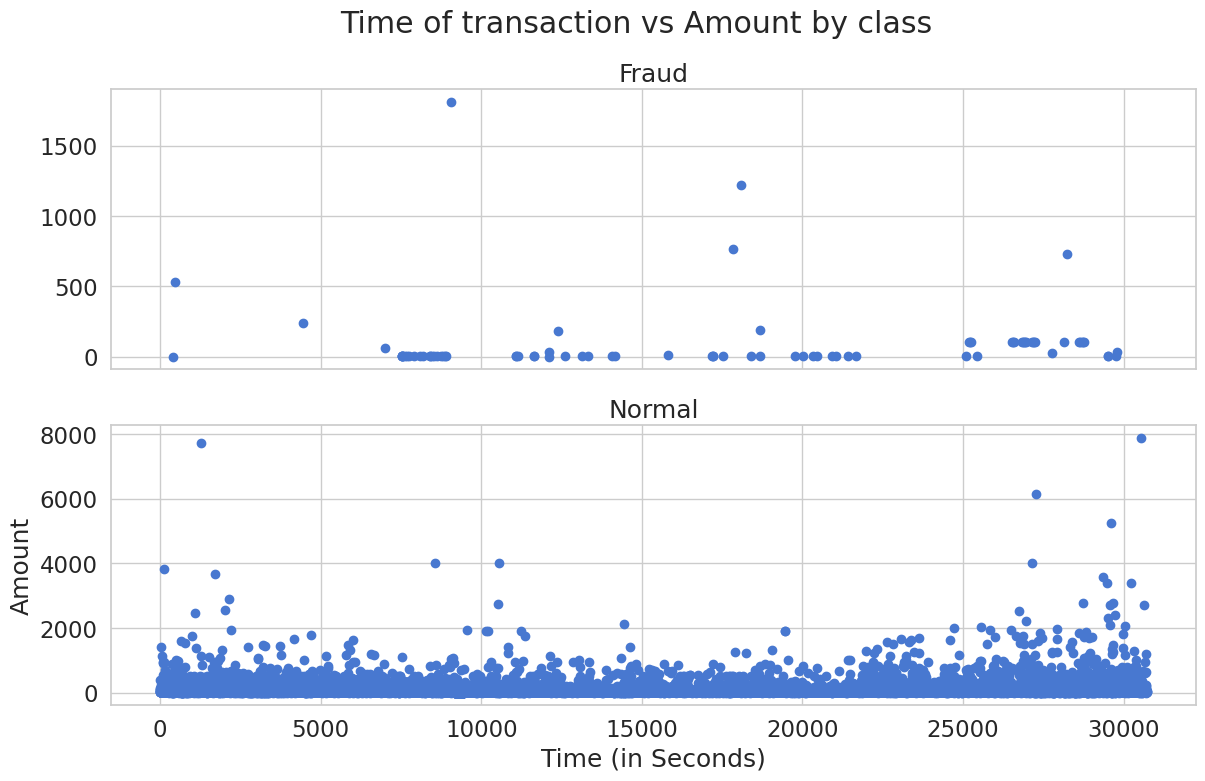

In [ ]:
# Two scatter plots are created to visualize the relationship between the 'Time' of the transaction and the 'Amount' of the transaction for both fraudulent and normal transactions.
# These plots can help identify any patterns or trends in time and amount across the two classes.
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(fraudsDF.Time, fraudsDF.Amount)
ax1.set_title('Fraud')

ax2.scatter(normalDF.Time, normalDF.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

## Part 3: Preparing the data
- Target: perform data preprocessing for the credit card transactions dataset

In [ ]:
# Drop the Time column (not going to use it) and use the scikit’s StandardScaler on the Amount
# The scaler removes the mean and scales the values to unit variance
transactionData = df.drop(['Time'], axis=1)
transactionData['Amount'] = StandardScaler().fit_transform(transactionData['Amount'].values.reshape(-1, 1))

Only train the model on the normal transactions.
Reserving the correct class on the test set will give us a way to evaluate the performance of our model.
We will reserve 20% of the data for testing:

In [ ]:
X_train, X_test = train_test_split(transactionData, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
#print(type(X_train))
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
#print(type(X_train))
X_test = X_test.values
y_test = y_test.values
print(y_test.size)

4000


## Part 4: Autoencoders and Building the model

- Target: define and train an Autoencoder for anomaly detection in credit card transactions

A class 'Autoencoder' is defined, which inherits from the 'nn.Module' class in PyTorch. It consists of an 'encoder' and a 'decoder'.
 - The 'encoder' part of the Autoencoder has a sequential architecture with a linear layer reducing the input dimension from 29 to 14, followed by a Tanh activation function, then another linear layer reducing the dimension from 14 to 7, and finally a LeakyReLU activation function.
 - The 'decoder' part is mirror of the encoder but in reverse order, expanding the dimensions back to the original size. It consists of two linear layers interleaved with Tanh and LeakyReLU activation functions.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(29, 14),
            nn.Tanh(),
            nn.Linear(14, 7),
            nn.LeakyReLU(),
            )

        self.decoder = nn.Sequential(
           nn.Linear(7, 7),
           nn.Tanh(),
           nn.Linear(7, 29),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = Autoencoder().double().cpu()

In [ ]:
# Hyperparameters for training such as number of epochs, minibatch size and learning rate are defined
num_epochs = 100
minibatch_size = 32
learning_rate = 1e-3

In [ ]:
# PyTorch's DataLoader is used to create training and testing data loaders with the defined batch sizes
# Mean squared error loss is chosen as the criterion to evaluate the model's performance, and the Adam optimizer is selected for training the model
# A dictionary 'history' is created to store the training loss for each epoch
train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)
history = {}
history['train_loss'] = []
history['test_loss'] = []

In [ ]:
# The model is trained for a defined number of epochs. In each epoch, the model forward propagates the input data, computes the loss, backpropagates the gradients, and updates the weights
# After each epoch, the average training loss is calculated, printed out, and stored in the 'history' dictionary
# The trained model's parameters are saved to a file using torch.save
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)


torch.save(model.state_dict(), './credit_card_model.pth')

epoch [1/100], loss:1.0596
epoch [2/100], loss:0.9163
epoch [3/100], loss:0.8550
epoch [4/100], loss:0.8275
epoch [5/100], loss:0.8097
epoch [6/100], loss:0.7943
epoch [7/100], loss:0.7781
epoch [8/100], loss:0.7680
epoch [9/100], loss:0.7619
epoch [10/100], loss:0.7572
epoch [11/100], loss:0.7537
epoch [12/100], loss:0.7504
epoch [13/100], loss:0.7476
epoch [14/100], loss:0.7448
epoch [15/100], loss:0.7424
epoch [16/100], loss:0.7395
epoch [17/100], loss:0.7372
epoch [18/100], loss:0.7349
epoch [19/100], loss:0.7333
epoch [20/100], loss:0.7309
epoch [21/100], loss:0.7290
epoch [22/100], loss:0.7271
epoch [23/100], loss:0.7261
epoch [24/100], loss:0.7245
epoch [25/100], loss:0.7230
epoch [26/100], loss:0.7221
epoch [27/100], loss:0.7208
epoch [28/100], loss:0.7199
epoch [29/100], loss:0.7191
epoch [30/100], loss:0.7183
epoch [31/100], loss:0.7178
epoch [32/100], loss:0.7169
epoch [33/100], loss:0.7162
epoch [34/100], loss:0.7161
epoch [35/100], loss:0.7153
epoch [36/100], loss:0.7150
e

## Part 5: Evaluation and reconstruction error without fraud
- Target:  visualize the loss and evaluate the model's performance in detecting fraudulent transactions

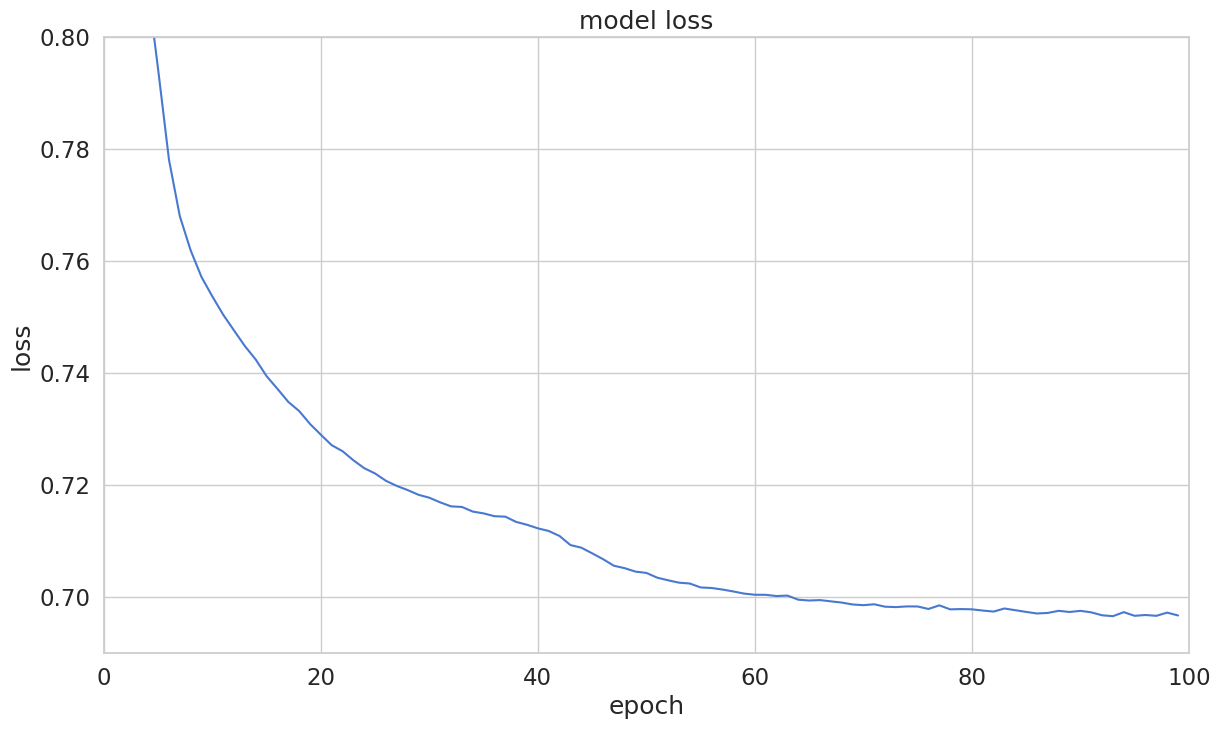

In [ ]:
# The training loss history is plotted over epochs
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0,100,0.69,0.80])
#plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [ ]:
# The model is set to evaluation mode with model.eval(). This turns off specific layers/parts of the model that behave differently during training, like dropout layers.
# A 'with torch.no_grad()' block is used to run model inference, which tells PyTorch that gradients don't need to be computed, thus saving memory.
# For each batch of data in the test loader, the model forward propagates the input, computes the loss with the criterion, and appends the loss to 'pred_losses'.
# A DataFrame 'reconstructionErrorDF' is created from 'pred_losses' and a new 'Class' column is added to it, which contains the actual class labels from 'y_test'.
# The 'describe' method of the DataFrame is called to display statistics of the 'reconstructionErrorDF' DataFrame.

pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
   # test_loss = 0
    for data in test_loader:
        inputs = data
        # print(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        #print(loss)
        pred_losses['pred_loss'].append(loss)
        #pred_losses = model([y_test.size, y_test])
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test
reconstructionErrorDF.describe()

,pred_loss,Class
count,4000.000000,4000.000000
mean,0.940631,0.004500
std,5.121045,0.066939
min,0.052205,0.000000
25%,0.238192,0.000000
50%,0.391142,0.000000
75%,0.616601,0.000000
max,137.082035,1.000000


In [ ]:
reconstructionErrorDF.describe()

,pred_loss,Class
count,4000.000000,4000.000000
mean,0.940631,0.004500
std,5.121045,0.066939
min,0.052205,0.000000
25%,0.238192,0.000000
50%,0.391142,0.000000
75%,0.616601,0.000000
max,137.082035,1.000000


Two histograms are then plotted - one for normal transactions and one for fraudulent ones, based on the model's prediction losses. This helps visualize the distribution of the prediction errors for the two classes.

Upon comparing the bar charts of two scenarios, it becomes evident that while non-fraudulent instances, as anticipated, exhibit minimal reconstruction losses, a notable number of fraudulent cases exhibit substantial reconstruction error losses. This observation suggests that the model is effective in identifying instances of fraud.

**Reconstruction errors — Non Fraudulent**

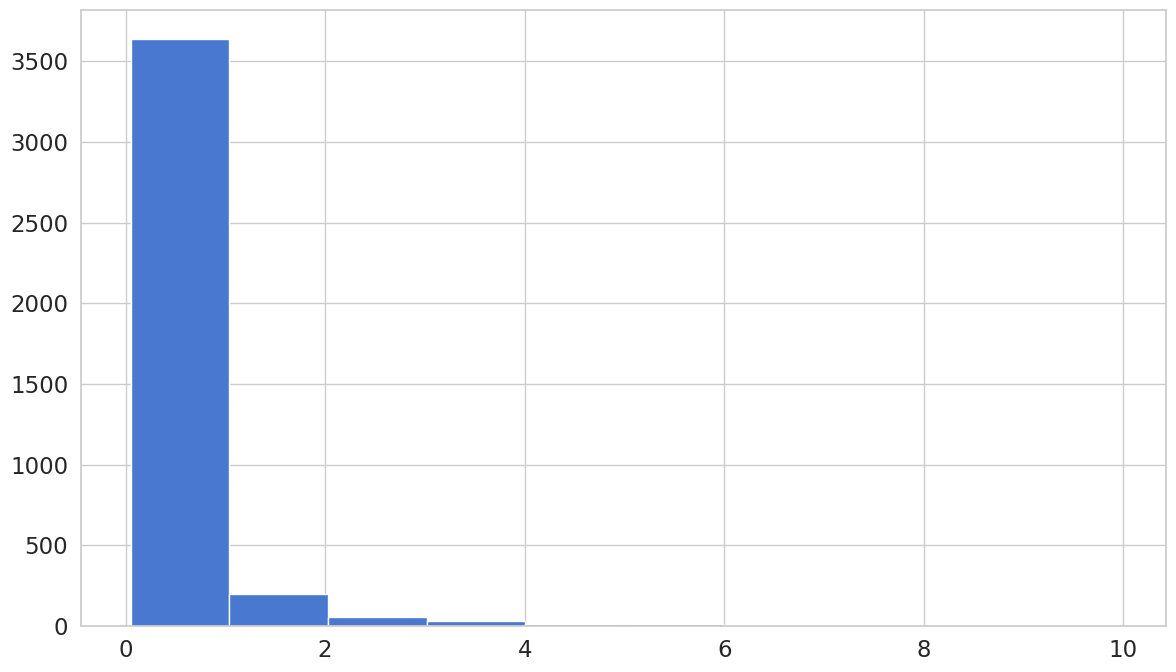

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 0) & (reconstructionErrorDF['pred_loss'] < 10)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

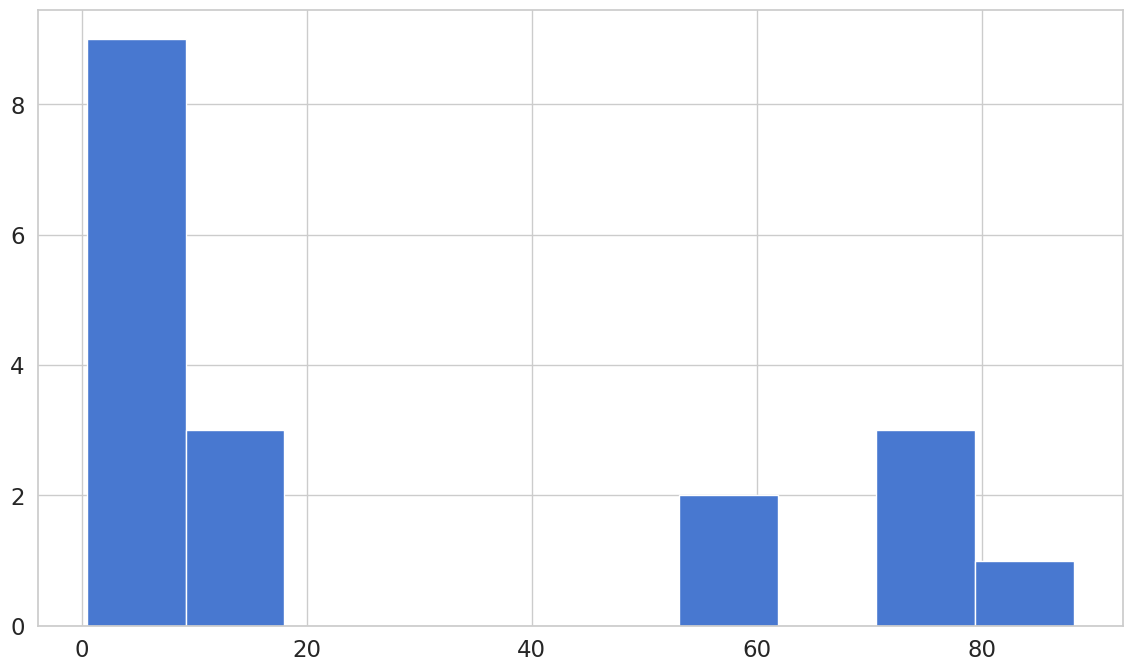

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 1) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

The Receiver Operating Characteristic (ROC) curve is plotted and the Area Under the Curve (AUC) is computed to evaluate the model's ability to distinguish between fraudulent and non-fraudulent transactions. This is a common way to visualize and quantify the performance of a binary classifier. The perfect classifier would have an AUC of 1, and a random guess would have an AUC of 0.5.

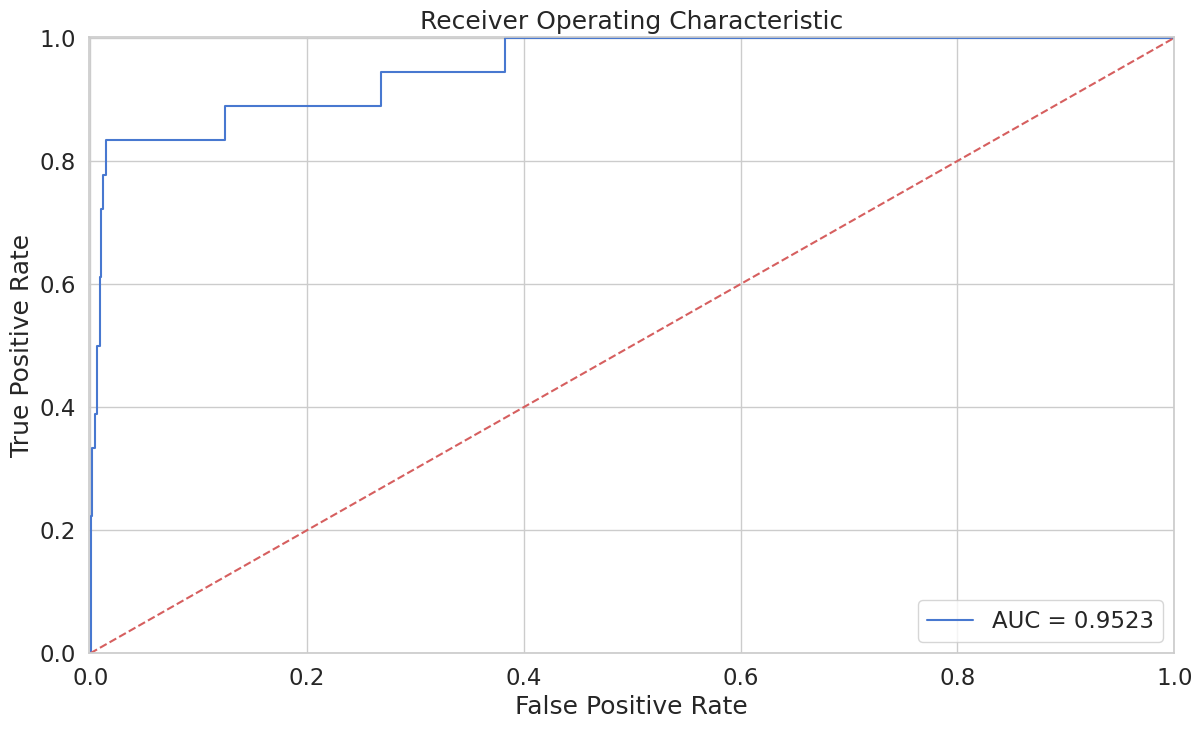

In [ ]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()